# Athena SQL Model

This example will create an athena table for [Jan 2017 taxi dataset](https://aws.amazon.com/blogs/big-data/build-a-data-lake-foundation-with-aws-glue-and-amazon-s3/).  You can improve performance if you convert into a parquet format.

Configure your notebook role with permissions to [query data from athena](https://aws.amazon.com/blogs/machine-learning/run-sql-queries-from-your-sagemaker-notebooks-using-amazon-athena/) and access the s3 staging bucket.

## Install libraries

Install the [Athena library](https://pypi.org/project/PyAthena/) for python and [tqdm](https://tqdm.github.io/)

In [1]:
import sys
!{sys.executable} -m pip install -q PyAthena
!{sys.executable} -m pip install -q tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import Data

Create an anthena database and external table for the imported nyc bit dataset.

In [2]:
import boto3
import sagemaker

# Initialize the boto session in us-east-1 region
boto_session = boto3.session.Session(region_name='us-east-1')
region = boto_session.region_name
bucket = sagemaker.session.Session(boto_session).default_bucket()

# Get the athena staging dir andtable
s3_staging_dir = 's3://{}/athena'.format(bucket)
db_name = 'nyc_taxi'
table_name = '{}.taxi_csv'.format(db_name)

print('s3 staging dir: {}'.format(s3_staging_dir))
print('athena table: {}'.format(table_name))

s3 staging dir: s3://sagemaker-us-east-1-691313291965/athena
athena table: nyc_taxi.taxi_csv


Make the bucket if it doesn't exist

In [3]:
!aws s3 mb s3://$bucket --region $region

make_bucket: sagemaker-us-east-1-691313291965


Query the nyc taxi dataset using [PandasCursor](https://pypi.org/project/PyAthena/#pandascursor) for improved performance

In [4]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
import pandas as pd

cursor = connect(s3_staging_dir=s3_staging_dir,
                 region_name=region,
                 cursor_class=PandasCursor).cursor()

In [5]:
sql_ddl_create_table = 'CREATE DATABASE IF NOT EXISTS {};'.format(db_name)

cursor.execute(sql_ddl_create_table)
print('Status: {}, Run time: {:.2f}s'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0))

Status: SUCCEEDED, Run time: 0.27s


In [6]:
sql_create_table = '''
CREATE EXTERNAL TABLE IF NOT EXISTS `{}` (
    `vendorid` bigint, 
    `lpep_pickup_datetime` string, 
    `lpep_dropoff_datetime` string, 
    `store_and_fwd_flag` string, 
    `ratecodeid` bigint, 
    `pulocationid` bigint, 
    `dolocationid` bigint, 
    `passenger_count` bigint, 
    `trip_distance` double, 
    `fare_amount` double, 
    `extra` double, 
    `mta_tax` double, 
    `tip_amount` double, 
    `tolls_amount` double, 
    `ehail_fee` string, 
    `improvement_surcharge` double, 
    `total_amount` double, 
    `payment_type` bigint, 
    `trip_type` bigint)
ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
STORED AS INPUTFORMAT 
    'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
    'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
    's3://aws-bigdata-blog/artifacts/glue-data-lake/data/'
TBLPROPERTIES (
    'columnsOrdered'='true', 
    'compressionType'='none', 
    'skip.header.line.count'='1')
'''.format(table_name)

cursor.execute(sql_create_table)
print('Status: {}, Run time: {:.2f}s'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0))

Status: SUCCEEDED, Run time: 0.55s


In [34]:
data_sql = '''
SELECT 
    total_amount, fare_amount, lpep_pickup_datetime, lpep_dropoff_datetime, trip_distance 
FROM {};
'''.format(table_name)
print('Querying...', data_sql)

data_df = cursor.execute(data_sql).as_pandas()
print('Status: {}, Run time: {:.2f}s, Data scanned: {:.2f}MB, Records: {:,}'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0, cursor.data_scanned_in_bytes/1024.0/1024.0, data_df.shape[0]))

data_df.head()

Querying... 
SELECT 
    total_amount, fare_amount, lpep_pickup_datetime, lpep_dropoff_datetime, trip_distance 
FROM nyc_taxi.taxi_csv;

Status: SUCCEEDED, Run time: 6.09s, Data scanned: 91.34MB, Records: 1,070,262


,total_amount,fare_amount,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance
0,20.30,16.5,2017-01-22 21:49:27,2017-01-22 22:07:02,4.74
1,26.16,20.5,2017-01-22 21:52:32,2017-01-22 22:15:40,5.56
2,10.56,7.5,2017-01-22 21:07:23,2017-01-22 21:14:19,1.61
3,12.96,9.5,2017-01-22 21:37:01,2017-01-22 21:46:48,2.28
4,11.16,8.0,2017-01-22 21:55:06,2017-01-22 22:03:13,1.71


Performance some simple feature engineering

In [43]:
# Add some date features
data_df['lpep_pickup_datetime'] = data_df['lpep_pickup_datetime'].astype('datetime64[ns]')
data_df['lpep_dropoff_datetime'] = data_df['lpep_dropoff_datetime'].astype('datetime64[ns]')
data_df['duration_minutes'] = (data_df['lpep_dropoff_datetime'] - data_df['lpep_pickup_datetime']).dt.seconds/60
data_df['hour_of_day'] = data_df['lpep_pickup_datetime'].dt.hour
data_df['day_of_week'] = data_df['lpep_pickup_datetime'].dt.dayofweek
data_df['week_of_year'] = data_df['lpep_pickup_datetime'].dt.weekofyear
data_df['month_of_year'] = data_df['lpep_pickup_datetime'].dt.month

In [44]:
# Exclude any outliers
data_df = data_df[(data_df.total_amount > 0) & (data_df.total_amount < 200) & 
                  (data_df.duration_minutes > 0) & (data_df.duration_minutes < 120) & 
                  (data_df.trip_distance > 0) & (data_df.trip_distance < 1000)].dropna()
print(data_df.shape)
data_df.head()

(1046381, 10)


,total_amount,fare_amount,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,duration_minutes,hour_of_day,day_of_week,week_of_year,month_of_year
0,20.30,16.5,2017-01-22 21:49:27,2017-01-22 22:07:02,4.74,17.583333,21.0,6.0,3.0,1.0
1,26.16,20.5,2017-01-22 21:52:32,2017-01-22 22:15:40,5.56,23.133333,21.0,6.0,3.0,1.0
2,10.56,7.5,2017-01-22 21:07:23,2017-01-22 21:14:19,1.61,6.933333,21.0,6.0,3.0,1.0
3,12.96,9.5,2017-01-22 21:37:01,2017-01-22 21:46:48,2.28,9.783333,21.0,6.0,3.0,1.0
4,11.16,8.0,2017-01-22 21:55:06,2017-01-22 22:03:13,1.71,8.116667,21.0,6.0,3.0,1.0


## Visualise Data


In [45]:
# Setup plotting defaults
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

mpl.style.use('seaborn')

mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

sample_df = data_df.sample(1000)

Inspect the distribution of data by date, and then cost/time metrics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd22bc659e8>,
      dtype=object)

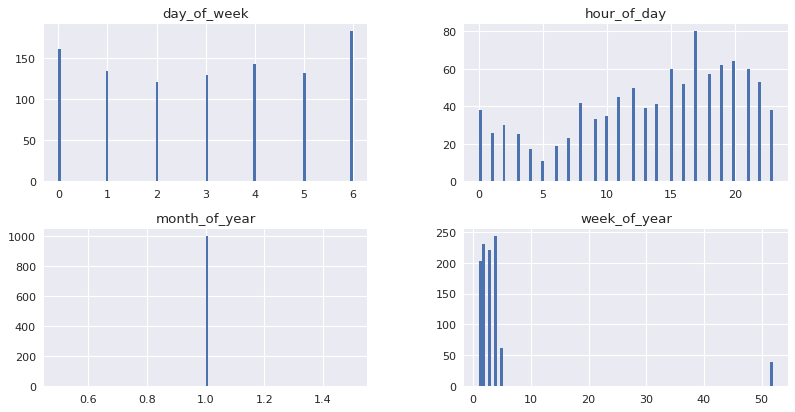

In [46]:
date_cols = ['hour_of_day', 'day_of_week', 'week_of_year', 'month_of_year']
sample_df[date_cols].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd22bb01ac8>,
      dtype=object)

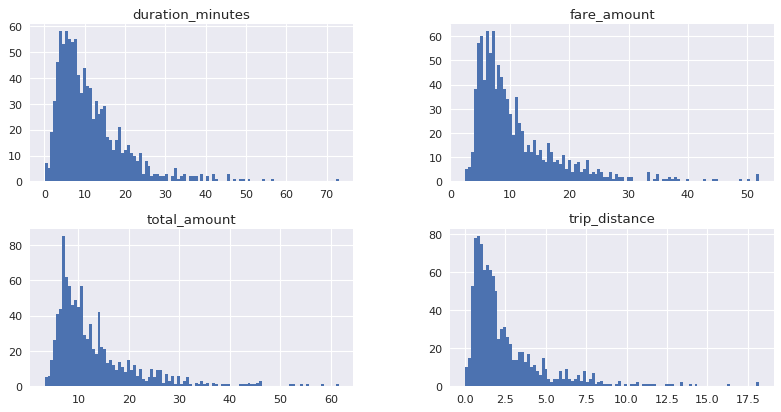

In [48]:
cost_cols =  ['total_amount', 'fare_amount', 'duration_minutes', 'trip_distance']
sample_df[cost_cols].hist(bins=100)

See if there is a correlation between duration in minutes and trip distance

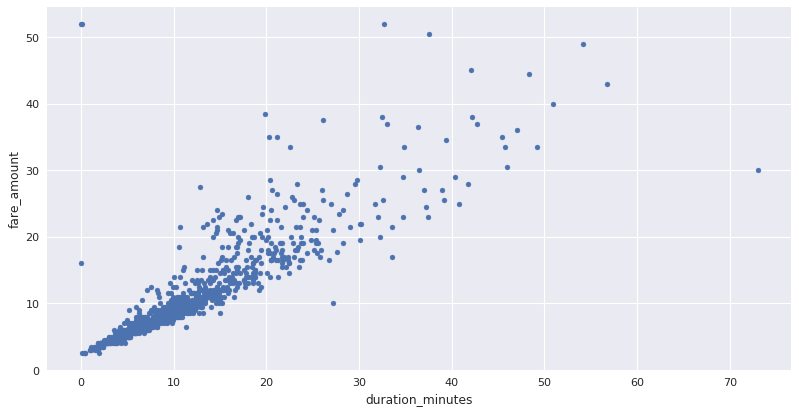

In [49]:
sample_df.plot.scatter(x='duration_minutes', y='fare_amount')

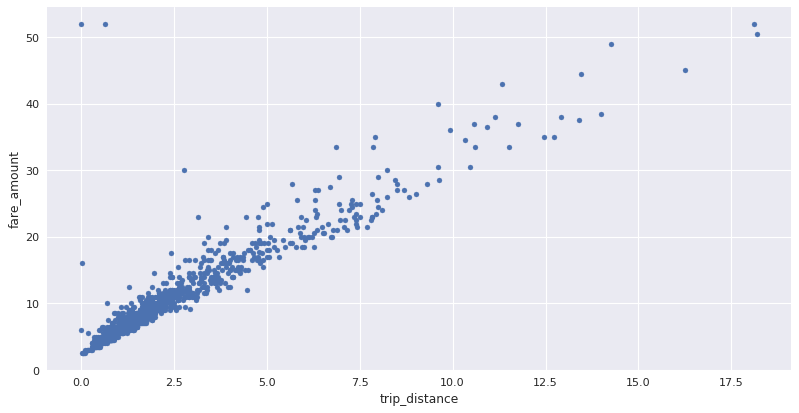

In [50]:
sample_df.plot.scatter(x='trip_distance', y='fare_amount')

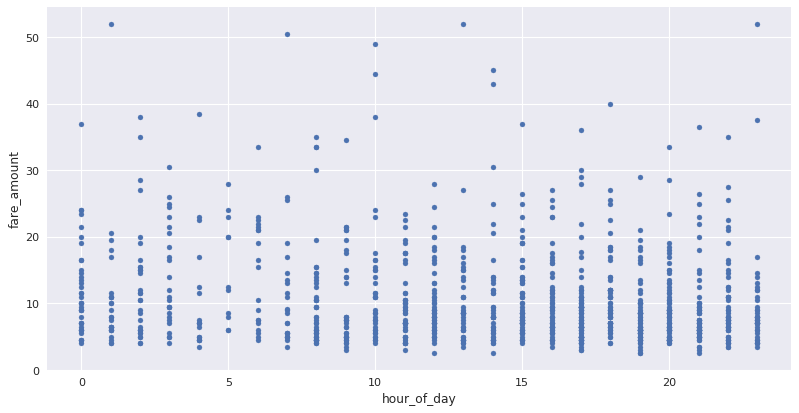

In [51]:
sample_df.plot.scatter(x='hour_of_day', y='fare_amount')

## Train Model

Build an XGBoost model to predict the total amount based on some fields

In [16]:
import boto3 
import sagemaker

sagemaker_session = sagemaker.session.Session(boto_session)
role = sagemaker.get_execution_role()
prefix = 'nyc-taxi'

print('bucket: {}, prefix: {}'.format(bucket, prefix))

bucket: sagemaker-us-east-1-691313291965, prefix: nyc-taxi


In [17]:
# Trip test split
from sklearn.model_selection import train_test_split

train_cols = ['total_amount', 'duration_minutes', 'trip_distance', 'hour_of_day']
train_df, val_df = train_test_split(data_df[train_cols], test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.50, random_state=42)

print('split train: {}, val: {}, test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

split train: 837104, val: 104638, test: 104639 


In [18]:
# Reset index and save files with target as first column
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Upload Data

Save train and validation as CSV with `total_amount` as first col but no headers

In [19]:
# Drop the tpep_pickup_datetime and save
train_df.to_csv('train.csv', index=False, header=False)
val_df.to_csv('validation.csv', index=False, header=False)

In [20]:
%%time

# Uplaod the files to s3 
s3_train_uri = sagemaker_session.upload_data('train.csv', bucket, prefix + '/data/training')
s3_val_uri = sagemaker_session.upload_data('validation.csv', bucket, prefix + '/data/validation')

CPU times: user 214 ms, sys: 30.8 ms, total: 245 ms
Wall time: 997 ms


Validate that we have uploaded these files succesfully

In [21]:
!aws s3 ls $s3_train_uri 
!aws s3 ls $s3_val_uri

2020-03-23 05:25:34   23700354 train.csv
2020-03-23 05:25:35    2966559 validation.csv


### Get estimator

In [22]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost', '0.90-1')
print('container: {}'.format(container))

container: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3


In [23]:
output_path = 's3://{}/{}/output'.format(bucket, prefix)
print('output: {}'.format(output_path))

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session)

output: s3://sagemaker-us-east-1-691313291965/nyc-taxi/output


In [24]:
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2, 
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=10000)

s3_input_train = sagemaker.s3_input(s3_data=s3_train_uri, content_type='csv')
s3_input_val = sagemaker.s3_input(s3_data=s3_val_uri, content_type='csv')

xgb.fit({'train': s3_input_train,  'validation': s3_input_val})

2020-03-23 05:25:36 Starting - Starting the training job...
2020-03-23 05:25:38 Starting - Launching requested ML instances.........
2020-03-23 05:27:09 Starting - Preparing the instances for training......
2020-03-23 05:28:36 Downloading - Downloading input data
2020-03-23 05:28:36 Training - Downloading the training image...
2020-03-23 05:28:58 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[05:29:00] 837104x3 matrix with 2511312 entries loaded from /opt/ml/i

### Deploy model

In [25]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

### Evalulate Model

Get predicitons for the validation set

In [26]:
from sagemaker.predictor import csv_serializer

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [27]:
%%time

import numpy as np
from tqdm import tqdm

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in tqdm(split_array):
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

# Get predictions and store in df
predictions = predict(val_df[train_cols[1:]].values)
predictions = pd.DataFrame({'total_amount_predictions': predictions })

100%|██████████| 210/210 [00:04<00:00, 45.49it/s]

CPU times: user 1.47 s, sys: 18.4 ms, total: 1.49 s
Wall time: 4.67 s


In [28]:
# Get the abs error between predictions
pred_df = val_df.join(predictions)
pred_df['error'] = abs(pred_df['total_amount']-pred_df['total_amount_predictions'])
pred_df.sort_values('error', ascending=False).head(10)

,total_amount,duration_minutes,trip_distance,hour_of_day,total_amount_predictions,error
80926,160.00,0.050000,0.08,19.0,20.669760,139.330240
36441,150.00,25.450000,1.56,3.0,17.868708,132.131292
31496,120.00,0.283333,0.08,4.0,7.605297,112.394703
2357,118.30,17.833333,4.51,23.0,19.775103,98.524897
51305,197.61,118.533333,53.10,14.0,104.829735,92.780265
77732,141.30,46.416667,12.14,16.0,48.566212,92.733788
7371,100.50,0.500000,0.12,23.0,8.080048,92.419952
132,178.50,41.366667,33.62,6.0,95.918167,82.581833
21145,91.00,10.316667,1.38,18.0,10.686583,80.313417
56765,100.00,0.083333,0.06,20.0,21.311424,78.688576


Print the `RMSE` validation metric

In [29]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(pred_df):
    return sqrt(mean_squared_error(pred_df['total_amount'], pred_df['total_amount_predictions']))

rmse(pred_df)

3.0754101574135873

Visualse the outlines vs predicted values

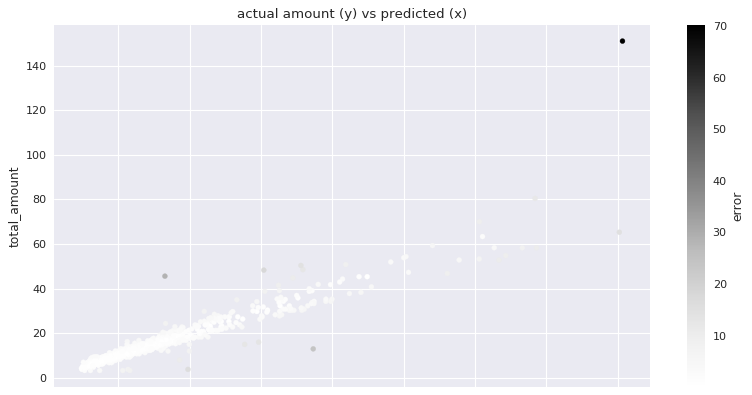

In [52]:
pred_df.tail(1000).plot.scatter(x='total_amount_predictions', y='total_amount', c='error', title='actual amount (y) vs predicted (x)')

## Create Athena UDF 

Create a [User Defined Function](https://aws.amazon.com/blogs/big-data/prepare-data-for-model-training-and-invoke-machine-learning-models-with-amazon-athena/) for the deployed endpoint so you can query directly in Athena.

In [31]:
endpoint_name = xgb_predictor.endpoint
print('endpoint: {}'.format(endpoint_name))

endpoint: sagemaker-xgboost-2020-03-23-05-25-35-962


`NOTE`: Athena ML is [in preview](https://aws.amazon.com/athena/faqs/#Preview_features).   To enable this Preview feature you need to create an Athena workgroup named `AmazonAthenaPreviewFunctionality` and run any queries attempting to federate to this connector, use a UDF, or SageMaker inference from that workgroup.

In [32]:
workgroup_name = 'AmazonAthenaPreviewFunctionality'

!aws athena create-work-group --name $workgroup_name --region $region


An error occurred (InvalidRequestException) when calling the CreateWorkGroup operation: WorkGroup AmazonAthenaPreviewFunctionality is already created


Using presto [datetime](https://prestodb.io/docs/0.172/functions/datetime.html) functions with inline query, rank by absolute error.

In [35]:
query_sql  = '''
USING FUNCTION predict_total(
  duration_minutes DOUBLE, 
  trip_distance DOUBLE, 
  hour_of_day DOUBLE) returns DOUBLE type SAGEMAKER_INVOKE_ENDPOINT
WITH (sagemaker_endpoint='{}')

SELECT 
    *, ABS(predicted_total_amount-total_amount) as error
FROM ( 
    SELECT
        *,
        predict_total(duration_minutes, trip_distance, hour_of_day) as predicted_total_amount
    FROM 
    (
        SELECT 
            total_amount,
            CAST(date_diff('minute', 
                CAST(lpep_pickup_datetime as timestamp), 
                CAST(lpep_dropoff_datetime as timestamp)) as DOUBLE) as duration_minutes,
            CAST(trip_distance as DOUBLE) as trip_distance,
            CAST(hour(CAST(lpep_pickup_datetime as timestamp)) as double) as hour_of_day
        FROM {}
        WHERE DAY(CAST(lpep_pickup_datetime as timestamp)) = {} -- Filter by day
    )
)
ORDER BY error DESC
LIMIT {};
'''.format(endpoint_name, table_name, 1, 10)
print('Querying...', query_sql)

query_df = cursor.execute(query_sql, work_group=workgroup_name).as_pandas()
print('Status: {}, Run time: {:.2f}s, Data scanned: {:.2f}MB, Records: {:,}'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0, cursor.data_scanned_in_bytes/1024.0/1024.0, query_df.shape[0]))

query_df

Querying... 
USING FUNCTION predict_total(
  duration_minutes DOUBLE, 
  trip_distance DOUBLE, 
  hour_of_day DOUBLE) returns DOUBLE type SAGEMAKER_INVOKE_ENDPOINT
WITH (sagemaker_endpoint='sagemaker-xgboost-2020-03-23-05-25-35-962')

SELECT 
    *, ABS(predicted_total_amount-total_amount) as error
FROM ( 
    SELECT
        *,
        predict_total(duration_minutes, trip_distance, hour_of_day) as predicted_total_amount
    FROM 
    (
        SELECT 
            total_amount,
            CAST(date_diff('minute', 
                CAST(lpep_pickup_datetime as timestamp), 
                CAST(lpep_dropoff_datetime as timestamp)) as DOUBLE) as duration_minutes,
            CAST(trip_distance as DOUBLE) as trip_distance,
            CAST(hour(CAST(lpep_pickup_datetime as timestamp)) as double) as hour_of_day
        FROM nyc_taxi.taxi_csv
        WHERE DAY(CAST(lpep_pickup_datetime as timestamp)) = 1 -- Filter by day
    )
)
ORDER BY error DESC
LIMIT 10;

Status: SUCCEEDED, Run time: 5.93

,total_amount,duration_minutes,trip_distance,hour_of_day,predicted_total_amount,error
0,240.00,0.0,0.00,4.0,18.295891,221.704109
1,276.64,49.0,48.20,8.0,96.595856,180.044144
2,140.80,1.0,0.20,10.0,4.583008,136.216992
3,203.16,43.0,38.59,11.0,96.354904,106.805096
4,7.00,193.0,52.96,22.0,103.960861,96.960861
5,141.30,46.0,12.14,16.0,48.747108,92.552892
6,-68.31,0.0,0.01,17.0,22.999298,91.309298
7,10.00,52.0,26.49,7.0,96.595856,86.595856
8,104.00,0.0,0.00,6.0,18.295891,85.704109
9,178.50,41.0,33.62,6.0,95.805733,82.694267
